# Train a CNN to try and predict stock prices

This follows closely the tensorflow tutorial from https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from market_analysis.dataset import get_stock_data
from market_analysis.features import get_Nday_return
from loguru import logger
import talib.abstract as ta
import tensorflow as tf
import matplotlib.pyplot as plt


logger.disable("market_analysis")

2024-12-21 14:51:07.179126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 14:51:07.179694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 14:51:07.182144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 14:51:07.194738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734792667.212257   23018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734792667.21

In [133]:
# Load in stock market data
df = get_stock_data("AZN.L", end_date=(2024, 12, 6), days=365.25 * 14)

[*********************100%***********************]  1 of 1 completed


In [159]:
# Get features
get_Nday_return(df, days=1, log=True)

df['INTRADAY_LOGRTN'] = df.eval('log(close/open)')

args = { # These parameters reduce noise
    "fastk_period": 14,
    "slowk_period": 7,
    "slowk_matype": 0,
    "slowd_period": 7,
    "slowd_matype": 0,
}

STOCH = ta.Function("STOCH", **args)(df)
df['STOCH_FAST'] = STOCH['slowk']
df['STOCH_DIFF'] = STOCH.eval('slowd-slowk')

STOCHRSI = ta.Function("STOCHRSI")(df)
df['STOCHRSI_FAST'] = STOCHRSI['fastk']
df['STOCHRSI_DIFF'] = STOCHRSI.eval('fastd-fastk')


df['BOP'] = ta.Function("BOP")(df)

# Format data

coloumns = ["INTRADAY_LOGRTN", "STOCH_FAST", "STOCH_DIFF", "STOCHRSI_FAST", 
            "STOCHRSI_DIFF", "BOP", "LOGRTN_D1"]
n = len(df)
train_df = df[1 : int(n * 0.7) - 30][coloumns]
val_df = df[int(n * 0.7) : int(n * 0.9)][coloumns]
test_df = df[int(n * 0.9) :][coloumns]

train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

assert train_df.isnull().sum().sum() == 0
assert val_df.isnull().sum().sum() == 0
assert test_df.isnull().sum().sum() == 0

column_indices = {name: i for i, name in enumerate(test_df.columns)}

In [198]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None
    ):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col="LOGRTN_D1", max_subplots=3):

        inputs, labels = self.example

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10, color='grey')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            colors = np.where(labels[n, :, label_col_index] > 0, "green", "red")
            plt.bar(
                self.label_indices,
                labels[n, :, label_col_index],
                label="True Value",
                facecolor=colors,
                edgecolor="k",
            )

            if model is not None:
                predictions = model(inputs)

                colors = np.where(predictions[n, :, label_col_index] > 0, "green", "red")
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Prediction",
                    c=colors,
                    s=64,
                    linestyle="",
                )

            if n == 0:
                plt.legend(loc="best")

            plt.axhline(0, c="k")
            plt.ylim(-0.05, 0.05)

        plt.xlabel("Time []")

In [199]:
# For training models

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [200]:
# Use this for plotting
wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=["LOGRTN_D1"],
)

# Use return of previous day to predict return on D + 1
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=["LOGRTN_D1"],
)

# Use past 8 days of stock market data to predict return D + 2
CONV_WIDTH = 8
SHIFT = 2
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=2,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=["LOGRTN_D1"],
)

# For plotting
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=["LOGRTN_D1"]
)

1) Predict next day to have same value as preceding day (the simplest possible prediction)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4921e-04 - mean_absolute_error: 0.0161  


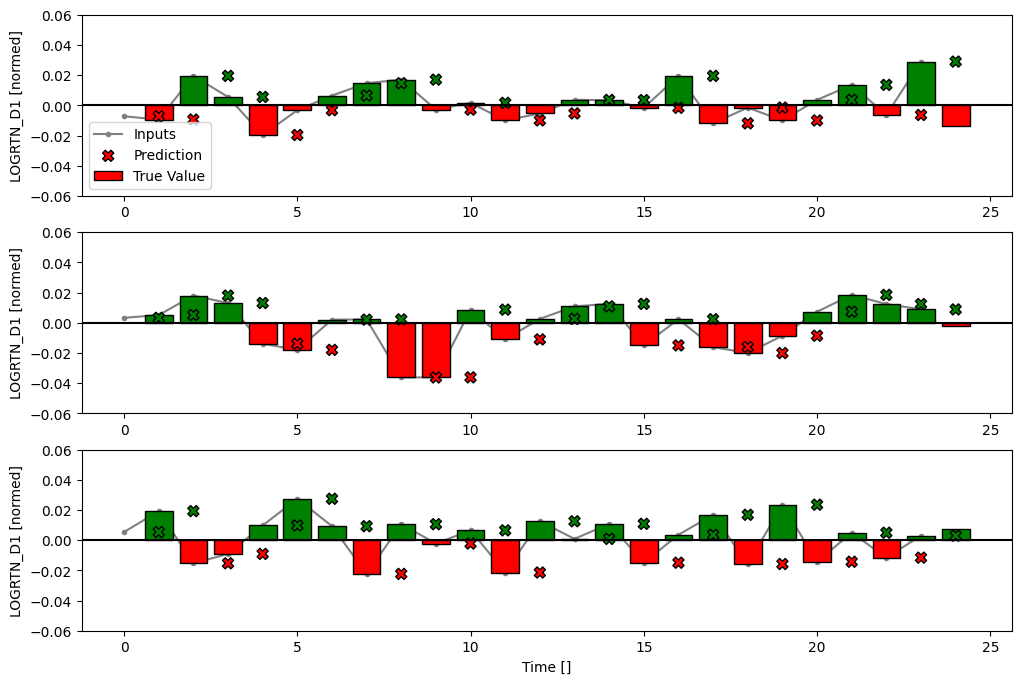

In [170]:
# Predict 1 day into future, assuming no change from current day
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


baseline = Baseline(label_index=column_indices["LOGRTN_D1"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val, return_dict=True)

performance = {}
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

wide_window.plot(baseline)

# Simple linear model (still using single day of data)

In [171]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [178]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0308 - val_loss: 2.9222e-04 - val_mean_absolute_error: 0.0127
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5815e-04 - mean_absolute_error: 0.0116 - val_loss: 2.8358e-04 - val_mean_absolute_error: 0.0124
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5158e-04 - mean_absolute_error: 0.0113 - val_loss: 3.7467e-04 - val_mean_absolute_error: 0.0148
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9774e-04 - mean_absolute_error: 0.0127 - val_loss: 2.4883e-04 - val_mean_absolute_error: 0.0116
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0534e-04 - mean_absolute_error: 0.0125 - val_loss: 2.5259e-04 - val_mean_absolute_error: 0.0120
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7477e-04 - mean_absolute_error: 0.0121 - val_loss: 3.8154e-04 - val_mean_absolute_error: 0.0149
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3963e-04 - mean_abs

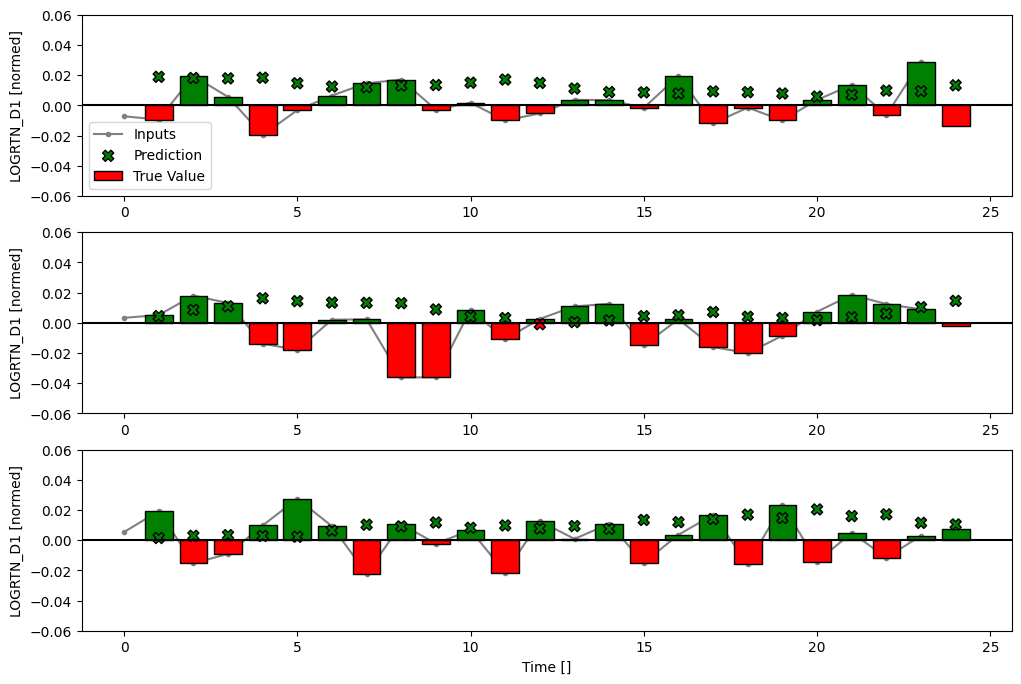

In [179]:
wide_window.plot(linear)


Deeper neural network

In [201]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4369 - mean_absolute_error: 0.8155 - val_loss: 0.1247 - val_mean_absolute_error: 0.2664
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0801 - mean_absolute_error: 0.2177 - val_loss: 0.0691 - val_mean_absolute_error: 0.1962
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - mean_absolute_error: 0.1787 - val_loss: 0.0444 - val_mean_absolute_error: 0.1569
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - mean_absolute_error: 0.1500 - val_loss: 0.0317 - val_mean_absolute_error: 0.1324
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - mean_absolute_error: 0.1235 - val_loss: 0.0286 - val_mean_absolute_error: 0.1300
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - mean_absolute_error: 0.1176 - val_loss: 0.0263 - val_mean_absolute_error: 0.1251
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 - mean_absolute_error: 0.1237 - val_loss: 0.024

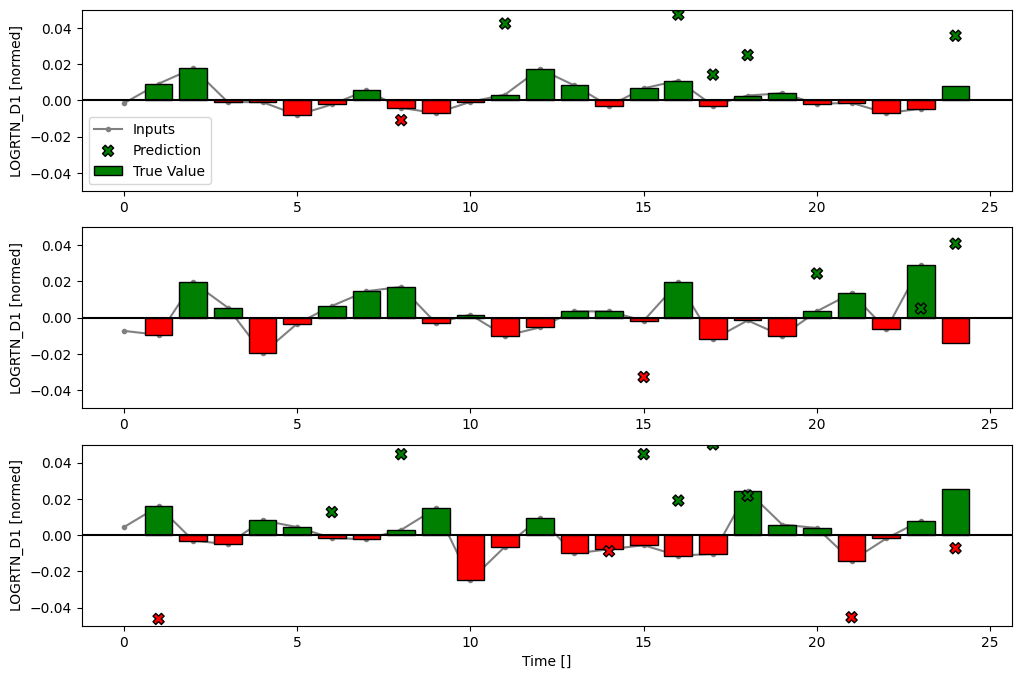

In [202]:
wide_window.plot(dense)


# CNN model with multiple days as input

In [230]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 52.2148 - mean_absolute_error: 5.3833 - val_loss: 5.1591 - val_mean_absolute_error: 1.7763
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6059 - mean_absolute_error: 1.4739 - val_loss: 2.3506 - val_mean_absolute_error: 1.1672
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7327 - mean_absolute_error: 1.0154 - val_loss: 1.5271 - val_mean_absolute_error: 0.9385
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1391 - mean_absolute_error: 0.8065 - val_loss: 1.0755 - val_mean_absolute_error: 0.7788
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8058 - mean_absolute_error: 0.6743 - val_loss: 0.8034 - val_mean_absolute_error: 0.6680
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6054 - mean_absolute_error: 0.5881 - val_loss: 0.6846 - val_mean_absolute_error: 0.6131
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4672 - mean_absolute_error: 0.5169 - val_loss: 0.50

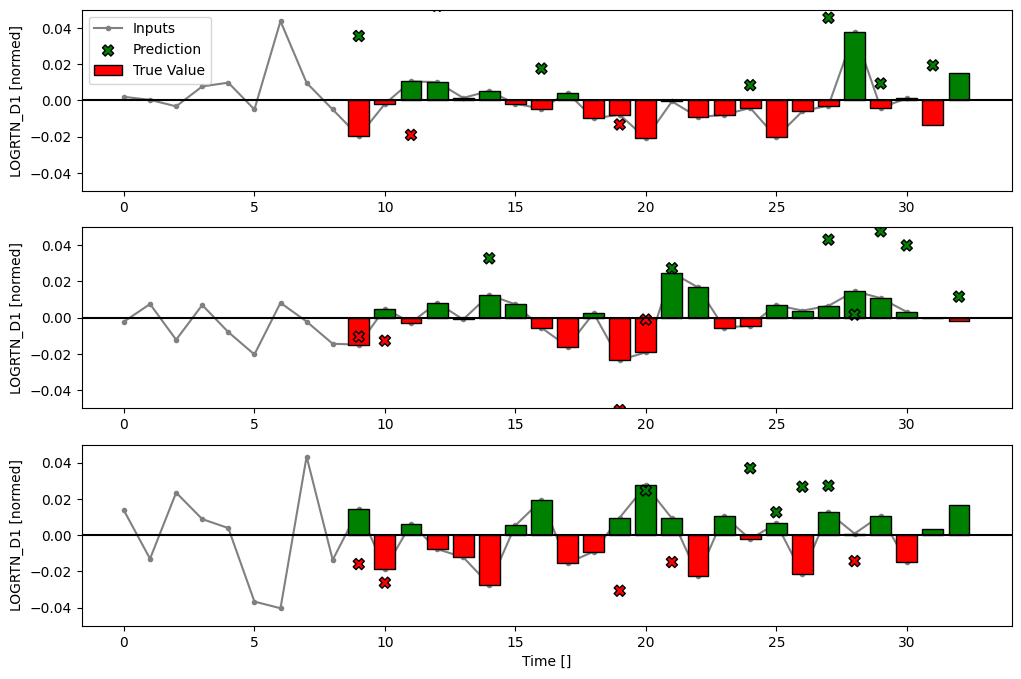

In [231]:
wide_conv_window.plot(conv_model)


# Conclusion

Predicting next day return is very difficult. In the under-fit scenario, predictions are not of the right scale.

As training is taken further, predictions seem to tend to zero. 

Will consider an alternative strategy next.